In [1]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(taxyvr)
library(cowplot)
install.packages("formattable")
library(formattable)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Investigation into Median Data Science Salaries

### INTRODUCTION

Increased use of data in decision-making across the economy has resulted in strong demand for those with Data Science qualifications.  Having witnessing a 650% increase in the last decade, employment growth is projected to be 31.4% from 2020 to 2030 (Zair, C. 2021; Data Science Jobs Guide).  Given this buoyant outlook, what can Data Science professionals expect salary wise? Our project will investigate the median salary of full-time Data Science professionals in the United States.  In addition, acknowledging the growing prevalence remote working arrangements — fully remote teams have increased from 2.3% to 20% (Ozimek, 2020) — we will explore whether there is a salary difference in remote majority vs minority positions. To accommodate for the right-skew of our sample distributions, we will analyse the interquartile range in addition to the median. Our report utilizes a dataset from Kaggle comprising of salary and other employment information anonymously submitted by data science professionals.

### PRELIMINARY RESULTS

In [2]:
original_data <- read_csv("ds_salaries.csv")
head(original_data)

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


In [3]:
# Cleaning the data to only show US residence, 0 and 100 remote ratio 
# and Full Time employment

clean_data <- original_data %>%
    filter(!is.na(salary_in_usd),
        employee_residence == "US",
            employment_type == "FT", 
        remote_ratio %in% c(0, 100)) %>%
    select(experience_level, salary_in_usd, remote_ratio)

head(clean_data)

experience_level,salary_in_usd,remote_ratio
<chr>,<dbl>,<dbl>
EN,72000,100
SE,190000,100
MI,135000,100
MI,87000,100
MI,85000,100
MI,98000,0


In [4]:
#This cell contains different summary data (min, max, median, mean, amount) related to the different groups being explored

remote_ratio_0_dist <-
    clean_data %>%
    filter(remote_ratio == 0)

remote_ratio_100_dist <-
    clean_data %>%
    filter(remote_ratio == 100)

remote_ratio_0_median <- remote_ratio_0_dist %>% 
    summarise(median_0 = median(salary_in_usd)) %>%
    pull()

remote_ratio_100_median <- remote_ratio_100_dist %>% 
    summarise(median_100 = median(salary_in_usd)) %>%
    pull()

remote_ratio_0_mean <- remote_ratio_0_dist %>%
    summarise(mean_0 = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

remote_ratio_100_mean <- remote_ratio_100_dist %>%
    summarise(mean_100 = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

remote_ratio_0_min <- remote_ratio_0_dist %>%
    summarise(min_0 = min(salary_in_usd)) %>%
    pull()


remote_ratio_0_max <- remote_ratio_0_dist %>%
    summarise(min_0 = max(salary_in_usd)) %>%
    pull()

remote_ratio_0_amount <- 
    clean_data %>%
    summarise(amount_0 = sum(remote_ratio == 0)) %>%
    pull()

remote_ratio_100_min <- 
    clean_data %>%
    filter(remote_ratio == 100) %>%
    summarise(min_100 = min(salary_in_usd)) %>%
    pull()

remote_ratio_100_max <- remote_ratio_100_dist %>%
    summarise(max_100 = max(salary_in_usd)) %>%
    pull()

remote_ratio_100_amount <- 
    clean_data %>%
    summarise(amount_100 = sum(remote_ratio == 100)) %>%
    pull()

overall_mean <-
    clean_data %>%
    summarise(overall_mean = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

overall_median <-
    clean_data %>%
    summarise(overall_median = median(salary_in_usd)) %>%
    pull()

overall_min <-
    clean_data %>%
    summarise(overall_min = min(salary_in_usd)) %>%
    pull()

overall_max <- 
    clean_data %>%
    summarise(overall_max = max(salary_in_usd)) %>%
    pull()

overall_amount <- remote_ratio_0_amount + remote_ratio_100_amount

remote_ratio_0_quartile_1 <- quantile(pull(remote_ratio_0_dist, salary_in_usd), 0.25)
remote_ratio_0_quartile_3 <- quantile(pull(remote_ratio_0_dist, salary_in_usd), 0.75)
remote_ratio_100_quartile_1 <- quantile(pull(remote_ratio_100_dist, salary_in_usd), 0.25)
remote_ratio_100_quartile_3 <- quantile(pull(remote_ratio_100_dist, salary_in_usd), 0.75)
overall_quartile_1 <- quantile(pull(clean_data, salary_in_usd), 0.25)
overall_quartile_3 <- quantile(pull(clean_data, salary_in_usd), 0.75)

### Table of Summary Statistics

In [5]:
categories <- c("remote minority", "remote majority", "overall")
min <- c(remote_ratio_0_min, remote_ratio_100_min, overall_min)
max <- c(remote_ratio_0_max, remote_ratio_100_max, overall_max)
mean <- c(remote_ratio_0_mean, remote_ratio_100_mean, overall_mean)
median <- c(remote_ratio_0_median, remote_ratio_100_median, overall_median)
frequency <- c(remote_ratio_0_amount, remote_ratio_100_amount, overall_amount)
first_quartile <- c(remote_ratio_0_quartile_1, remote_ratio_100_quartile_1, overall_quartile_1)
third_quartile <- c(remote_ratio_0_quartile_3, remote_ratio_100_quartile_3, overall_quartile_3)

ratio_data_frame <- data.frame(categories, min, max, mean, median, first_quartile, third_quartile, frequency)

new_table <- formattable(ratio_data_frame, align = c("l", rep("r", NCOL(ratio_data_frame) -1)))
new_table

categories,min,max,mean,median,first_quartile,third_quartile,frequency
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
remote minority,54000,450000,141254,130000,99050,172500,67
remote majority,25000,600000,150821,140000,110000,175000,244
overall,25000,600000,148760,140000,106260,175000,311


### Histogram Salary Distributions by Remote Category

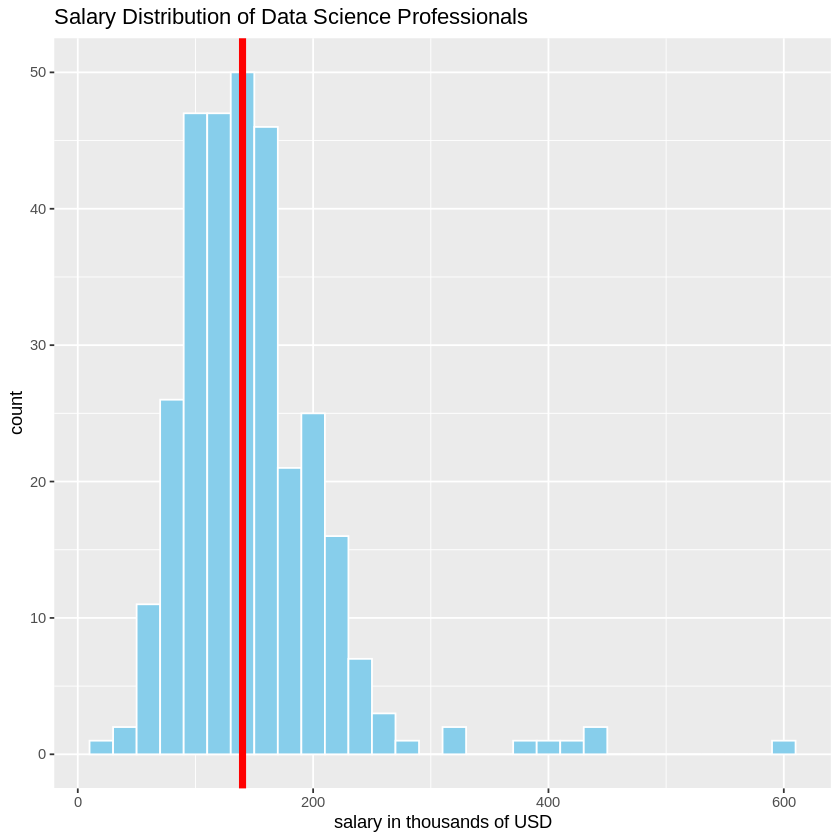

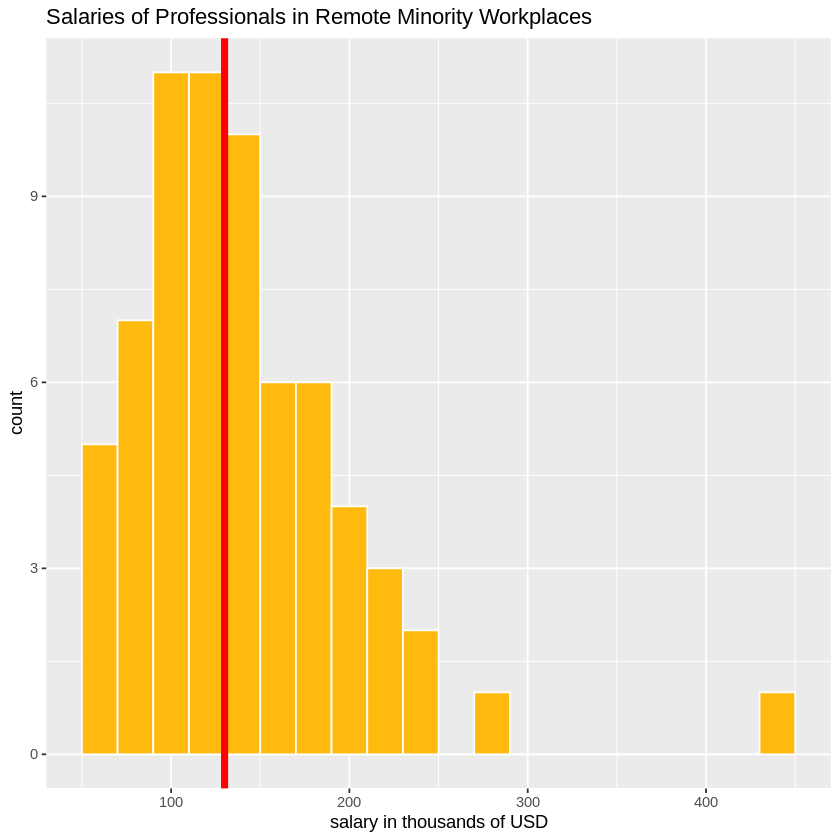

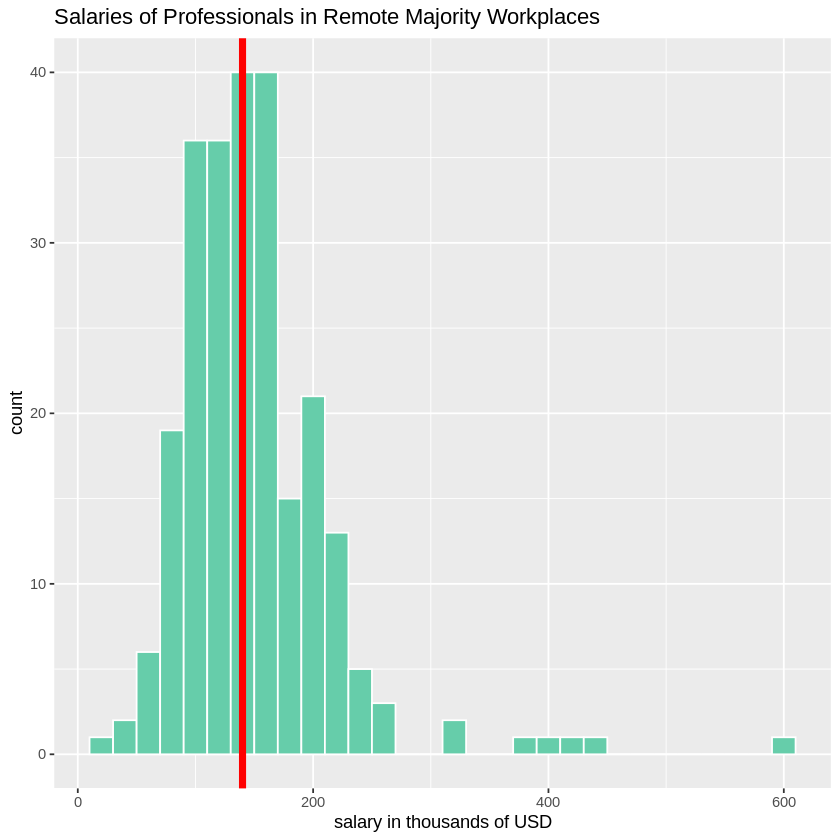

In [6]:
remote_ratio_0_plot <-
    remote_ratio_0_dist %>%
    ggplot(aes(x = salary_in_usd/1000)) + 
    geom_histogram(binwidth = 20, color="white", fill="darkgoldenrod1") +
    geom_vline(xintercept = remote_ratio_0_median/1000, color="red", size=2) +
    xlab("salary in thousands of USD") +
    ggtitle("Salaries of Professionals in Remote Minority Workplaces")

remote_ratio_100_plot <-
    remote_ratio_100_dist %>%
    ggplot(aes(x = salary_in_usd/1000)) + 
    geom_histogram(binwidth = 20, color="white", fill="aquamarine3") +
    geom_vline(xintercept = remote_ratio_100_median/1000, color="red", size=2) +
    xlab("salary in thousands of USD") +
    ggtitle("Salaries of Professionals in Remote Majority Workplaces")


overall_plot <-
    clean_data %>%
    ggplot(aes(x = salary_in_usd/1000)) +
    geom_histogram(binwidth = 20, color="white", fill="skyblue") +
    geom_vline(xintercept = overall_median/1000, color="red", size=2) +
    xlab("salary in thousands of USD") +
    ggtitle("Salary Distribution of Data Science Professionals")

overall_plot

remote_ratio_0_plot
remote_ratio_100_plot

### Boxplot of Salary Distribution by Remote Category

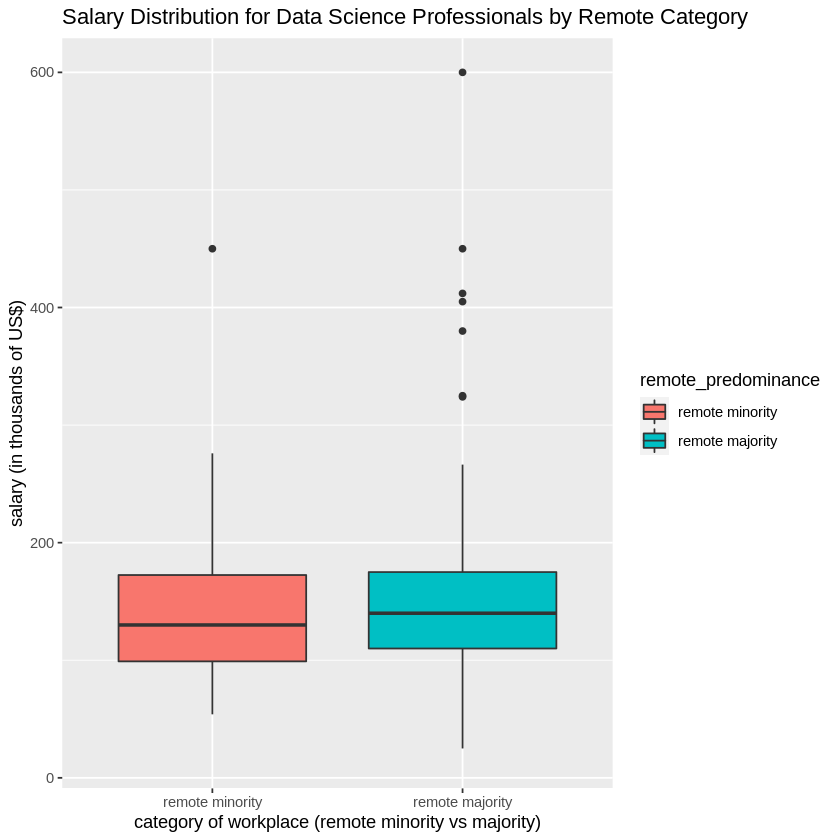

In [7]:
# Boxplots of the data for ease of comparison

clean_data$remote_predominance <- factor(clean_data$remote_ratio,
                                levels=c(0, 100),
                                labels=c("remote minority", "remote majority"))

remote_ratio_boxplot <- 
    clean_data %>%
    ggplot(aes(y = salary_in_usd/1000, x = remote_predominance, fill=remote_predominance)) +
    geom_boxplot() +
    coord_cartesian(ylim = c(20, 600)) + 
    xlab("category of workplace (remote minority vs majority)") +
    ylab("salary (in thousands of US$)") +
    ggtitle("Salary Distribution for Data Science Professionals by Remote Category")

remote_ratio_boxplot

### METHODS

Information within the dataset is self-reported, hence there is potential for selection bias.  However, because the submissions are anonymous, overall we may rely on the truthfulness of the submissions.  The data provides a reasonable number of observations (approximately 350) and is current (from 2020 to 2022). 

Importantly, the Central Limit Theorem appears to hold, hence statistical inference may be utilized.  This is because: 
(1) each analyzed group has more than 30 observations, 
(2) our sample has less than 10% of the total number of full-time data scientists in the US (estimated at approximately 20,000) and, 
(3) notwithstanding selection bias discussed above, the sample is reasonably random. 
 
Performing a preliminary investigation, USD 140,000 was obtained as an estimate for the median income of full-time US data science professionals.  Our investigation also found that the median income for those working in remote-majority offices is USD 140,000 whereas the median income for those in remote-minority offices is USD 130,000.  On the basis of this preliminary investigation, it appears workers in remote majority workplaces can expect a higher salary than their non-remote counterparts.
 
However, noting the two groups have substantial overlap in their interquartile range, that their medians are close to each other, and the presence of randomness and other confounding factors, this assessment is not sufficient to make definite conclusions on median salaries.  We will thus utilize bootstrapping of the sample to produce a 90% confidence interval of the estimated median salary for full time data science professionals working in the US.
 
In addition, we will conduct a hypothesis test (10% significance level) to further investigate whether there is a true difference in median salaries, with our null hypothesis being that there is no difference in median pay between data science professionals employed remotely compared to non-remote predominant offices.  Our alternative hypothesis is that there is a difference in median income between these two groups.
 
We expect to find a statistically significant difference in the true median income between remote vs non-remote working data science professionals. We hope this investigation will assist those data science professionals entering the field to better assess their income opportunities. Additionally, considering remote employees have reported to be significantly happier than their non-remote counterparts (Elshaiekh et al., 2018), we hope this report will provide the salary insights necessary to inform decisions whether to pursue a remote vs non-remote career. Future questions would likely include whether confounding factors influenced differences in median salary observed, sand salary trends.

### REFERENCES

Bhatia, R, (2022), Data Science Job Salaries, [Data set]. Kaggle. https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries. 

Data Science Jobs Guide: Resources for a Career in Tech. (2022, July 21). Coursera. https://www.coursera.org/articles/data-science-jobs.

Elshaiekh, N. E. M., Hassan, Y. A. A., & Abdallah, A. A. A. (2018). The Impacts of Remote Working on Workers Performance. 2018 International Arab Conference on Information Technology (ACIT), 1–5. https://doi.org/10.1109/ACIT.2018.8672704

Ozimek, A. (2020). The Future of Remote Work. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.3638597.

Zaire, C. (2021, November 8). Is Data Science Still a Rising Career in 2021. Towards Data Science. https://towardsdatascience.com/is-data-science-still-a-rising-career-in-2021-722281f7074c.